__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import contextily as ctx
# from shapely.geometry import Polygon

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data_land.pkl'

In [5]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

6636


,title,adr,latitude,longitude,priceM,ts
4584,"Участок 5,3 сот. (ИЖС)","Севастополь, с. Фруктовое",44.68,33.60,0.82,2022-09-16 15:10:34.059
2268,"Участок 4,1 сот. (ИЖС)","Севастополь, Балаклава, Снайперская ул., 18",44.51,33.59,1.70,2022-09-13 13:56:54.600
5043,Участок 4 сот. (ИЖС),"Севастополь, жилищно-строительное товарищество индивидуальных застройщиков Сосновый Бор, Хвойный тупик, 5",44.57,33.48,4.70,2022-09-16 15:10:34.059


In [6]:
df.loc[ df['adr']=='Севастополь, Чёрное море', ['latitude','longitude'] ] = None

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6636 entries, 0 to 6635
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   avito_id            6636 non-null   int64         
 1   title               6636 non-null   object        
 2   price               6636 non-null   int64         
 3   obj_name            6636 non-null   object        
 4   adr                 6636 non-null   object        
 5   description         6636 non-null   object        
 6   avito_page          6636 non-null   int64         
 7   ts                  6636 non-null   datetime64[ns]
 8   place               6636 non-null   object        
 9   area                6636 non-null   float64       
 10  is_IJS              6636 non-null   bool          
 11  priceM              6636 non-null   float64       
 12  priceMU             6636 non-null   float64       
 13  area_size_category  6636 non-null   category    

In [8]:
df.sample(3)[cols]

,title,adr,latitude,longitude,priceM,ts
1468,Участок 16 сот. (ИЖС),"Севастополь, пос. городского типа Кача, садоводческое товарищество Маяк-Кача, сектор А",44.80,33.54,1.60,2022-09-12 13:51:16.745
4494,"Участок 6,4 сот. (ИЖС)","Севастополь, Красивая ул.",44.59,33.47,8.30,2022-09-16 15:10:34.059
3335,Участок 5 сот. (ИЖС),"Севастополь, ул. Абазы, 4",44.55,33.54,6.00,2022-09-15 10:31:26.039


In [9]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

6636
6629


### ограничиваем тип объекта 

In [10]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [11]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
6257,Участок 5 сот. (ИЖС),"Севастополь, Балаклава, Земляничная ул.",44.51,33.62,4.85
284,Участок 9 сот. (ИЖС),"Севастополь, Молочный пер.",44.58,33.50,6.00
6248,Участок 6 сот. (ИЖС),"Севастополь, ул. Горпищенко, 109/30",44.58,33.58,5.40


In [12]:
del df

In [13]:
gdf[['title','priceM','area_size_category','geometry']].sample(100).explore('area_size_category', legend=True) 

## общая статистика изменение цены

In [14]:
ts = '2022-08-01' # ограничиваем дату

In [15]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['area_size_category','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)
stat

count  mean   std  min  10%   25%   50%   75%  \
area_size_category dt                                                          
<1                 2022-09-08   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-12   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-13   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-15   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-16   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-19   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
1-2                2022-09-08   3.00  1.80  0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-12   3.00  1.80  0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-13   3.00  1.80  0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-15   3.00  1.77  0.06 1.70 1.72  1.75  1.80  1.80   
                   2022-09-16   3.00  1.77  0.06 1.70 1.72  1.75  1.80  1.80   
                   2022-09-19   2.00  1.80  0.00 1.80 1.80  1.80  1.80  1.80   
2-4                2022-09-08 143.00  3.46  1.87 1.15 1.59  2.05  2.85  4.38   
                   2022-09-12 144.00  3.61  2.34 1.15 1.61  2.17  2.88  4.50   
                   2022-09-13 149.00  3.57  2.29 1.15 1.60  2.10  2.99  4.50   
                   2022-09-15 152.00  3.59  2.28 1.15 1.70  2.19  2.92  4.50   
                   2022-09-16 148.00  3.60  2.26 1.15 1.70  2.20  3.00  4.50   
                   2022-09-19 147.00  3.51  2.26 1.15 1.65  2.10  2.75  4.50   
4-8                2022-09-08 518.00  4.52  3.41 1.10 1.90  2.50  3.50  5.20   
                   2022-09-12 550.00  4.55  4.02 1.10 1.90  2.50  3.50  5.20   
                   2022-09-13 553.00  4.48  3.99 1.10 1.86  2.50  3.40  5.10   
                   2022-09-15 550.00  4.43  3.86 1.10 1.85  2.45  3.45  5.07   
                   2022-09-16 541.00  4.49  4.17 1.10 1.85  2.45  3.35  5.20   
                   2022-09-19 544.00  4.41  3.86 1.10 1.85  2.40  3.40  5.20   
8-20               2022-09-08 348.00  6.40  6.57 1.10 2.00  3.00  4.60  7.41   
                   2022-09-12 343.00  6.28  6.19 1.10 2.00  3.00  4.60  7.00   
                   2022-09-13 344.00  6.37  6.24 1.10 2.00  3.00  4.60  7.03   
                   2022-09-15 349.00  6.40  6.28 1.10 2.00  3.00  4.50  7.00   
                   2022-09-16 344.00  6.39  6.25 1.10 2.00  3.00  4.50  7.00   
                   2022-09-19 345.00  6.42  6.47 1.10 2.00  2.90  4.50  7.00   
20+                2022-09-08  35.00 34.26 30.52 1.10 5.70 14.00 26.00 44.00   
                   2022-09-12  37.00 31.74 30.65 1.10 2.90 10.00 21.00 38.00   
                   2022-09-13  37.00 33.43 31.28 1.10 2.96 12.00 21.00 50.00   
                   2022-09-15  42.00 31.62 33.40 1.10 2.91  8.30 17.25 37.75   
                   2022-09-16  39.00 33.62 33.84 2.10 2.98  9.50 19.00 44.00   
                   2022-09-19  43.00 32.80 33.04 2.10 2.92  7.90 19.00 45.00   

                                90%    max  
area_size_category dt                       
<1                 2022-09-08 13.61  15.00  
                   2022-09-12 13.61  15.00  
                   2022-09-13 13.61  15.00  
                   2022-09-15 13.61  15.00  
                   2022-09-16 13.61  15.00  
                   2022-09-19 13.61  15.00  
1-2                2022-09-08  1.88   1.90  
                   2022-09-12  1.88   1.90  
                   2022-09-13  1.88   1.90  
                   2022-09-15  1.80   1.80  
                   2022-09-16  1.80   1.80  
                   2022-09-19  1.80   1.80  
2-4                2022-09-08  6.00  11.70  
                   2022-09-12  6.14  20.00  
                   2022-09-13  6.00  20.00  
                   2022-09-15  5.98  20.00  
                   2022-09-16  5.80  20.00  
                   2022-09-19  5.80  20.00  
4-8                2022-09-08  8.13  29.00  
                   2022-09-12  8.00  60.00  


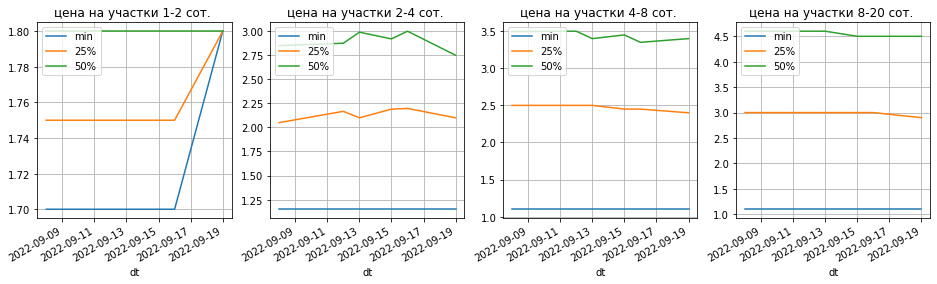

In [16]:
import matplotlib.pyplot as plt

# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
sizes = [ '1-2', '2-4', '4-8', '8-20', ]

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4))
for i,s in enumerate(sizes): 
    stat.loc[s,['min','25%','50%']].plot(grid=True, title=f'цена на участки {s} сот. ',ax=ax[i])

### район поиска

In [17]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_all.explore()

### гексагональная сетка

In [18]:
import h3
from shapely.geometry import Polygon
    
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [19]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0] )
print(len(grid))
grid.sample(2)

36


,hex_id,geometry
11,862d28b07ffffff,"POLYGON ((33.84682 44.71360, 33.82530 44.68427, 33.85210 44.65544, 33.90040 44.65595, 33.92194 44.68527, 33.89516 44.71410, 33.84682 44.71360))"
26,862d2895fffffff,"POLYGON ((33.56756 44.59377, 33.54614 44.56432, 33.57303 44.53552, 33.62132 44.53616, 33.64275 44.56559, 33.61589 44.59440, 33.56756 44.59377))"


### медиана актуальной цены

In [20]:
# новые предложения
gdf_ = gdf[ (gdf['dt']>ts)  ] # & (gdf['priceM']<15.)

grid_values = ( 
    grid
    .sjoin(gdf_, how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [21]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"


In [22]:
frames.explore('area_name')

In [23]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
'Севастополь, кр.горка',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

6629
235


In [24]:
# новые (актуальные) предложения
cols=['title','priceM','adr','area_size_category','geometry']
gdf_[gdf_['ts']>ts][cols].explore( 'area_size_category',legend=True)

### изменение цены

In [25]:
stat = (
    gdf_.query('priceM>1.')
    .groupby(['area_size_category','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)
stat

count   mean  std    min    10%    25%    50%  \
area_size_category dt                                                          
2-4                2022-09-08   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-12   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-13   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-15   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-16   5.00   2.85 0.48   2.60   2.60   2.60   2.65   
                   2022-09-19   5.00   2.85 0.48   2.60   2.60   2.60   2.65   
4-8                2022-09-08  22.00   3.75 2.17   1.60   2.00   2.23   2.75   
                   2022-09-12  25.00   3.48 1.89   1.45   1.80   2.20   2.80   
                   2022-09-13  24.00   3.27 1.61   1.45   1.80   2.20   2.75   
                   2022-09-15  25.00   3.21 1.61   1.45   1.80   2.20   2.70   
                   2022-09-16  24.00   3.30 1.67   1.45   1.80   2.15   2.75   
                   2022-09-19  24.00   3.35 1.67   1.45   1.80   2.15   2.90   
8-20               2022-09-08  10.00   5.81 4.85   1.65   2.42   3.12   4.10   
                   2022-09-12   9.00   5.96 4.47   1.65   2.81   3.20   4.25   
                   2022-09-13  10.00   6.18 4.27   1.65   2.96   3.39   4.53   
                   2022-09-15  11.00   5.31 4.25   1.65   2.15   2.85   3.95   
                   2022-09-16  10.00   5.58 4.38   1.65   2.10   3.12   4.10   
                   2022-09-19   9.00   5.76 4.61   1.65   2.05   3.10   4.25   
20+                2022-09-08   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-12   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-13   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-15   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-16   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-19   1.00 120.00  NaN 120.00 120.00 120.00 120.00   

                                 75%    90%    max  
area_size_category dt                               
2-4                2022-09-08   2.95   3.40   3.70  
                   2022-09-12   2.95   3.40   3.70  
                   2022-09-13   2.95   3.40   3.70  
                   2022-09-15   2.95   3.40   3.70  
                   2022-09-16   2.70   3.30   3.70  
                   2022-09-19   2.70   3.30   3.70  
4-8                2022-09-08   4.78   7.86   8.50  
                   2022-09-12   4.50   5.88   8.50  
                   2022-09-13   3.97   4.80   8.00  
                   2022-09-15   3.80   4.80   8.00  
                   2022-09-16   4.50   4.94   8.00  
                   2022-09-19   4.50   4.94   8.00  
8-20               2022-09-08   5.55  12.41  17.00  
                   2022-09-12   5.80  12.52  15.00  
                   2022-09-13   7.60  12.21  15.00  
                   2022-09-15   5.30  11.90  15.00  
                   2022-09-16   5.55  12.21  15.00  
                   2022-09-19   5.80  12.52  15.00  
20+                2022-09-08 120.00 120.00 120.00  
                   2022-09-12 120.00 120.00 120.00  
                   2022-09-13 120.00 120.00 120.00  
                   2022-09-15 120.00 120.00 120.00  
                   2022-09-16 120.00 120.00 120.00  
                   2022-09-19 120.00 120.00 120.00

In [26]:
gdf_['area_size_category'].unique()

['8-20', '4-8', '2-4', '20+']
Categories (6, object): ['<1' < '1-2' < '2-4' < '4-8' < '8-20' < '20+']

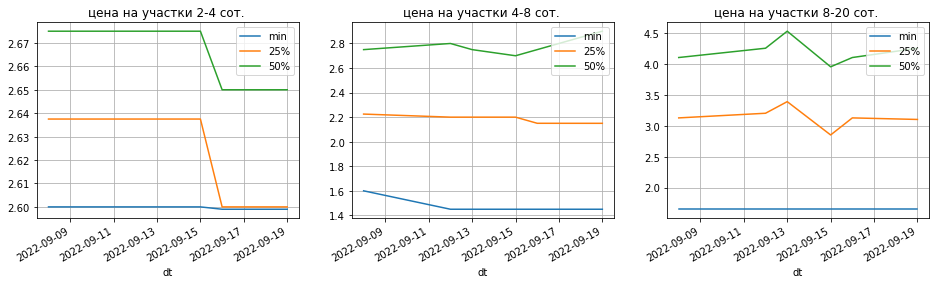

In [27]:
import matplotlib.pyplot as plt

# sizes = gdf_['area_size_category'].unique()
# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
sizes = [ '2-4', '4-8', '8-20', ]

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4))
for i,s in enumerate(sizes): 
    stat.loc[s,['min','25%','50%']].plot(grid=True, title=f'цена на участки {s} сот. ',ax=ax[i])

### гексагональная сетка

In [28]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

32


,hex_id,geometry
4,892d2895c93ffff,"POLYGON ((33.54568 44.57444, 33.54536 44.57265, 33.54744 44.57148, 33.54985 44.57211, 33.55018 44.57390, 33.54809 44.57506, 33.54568 44.57444))"
1,892d289422bffff,"POLYGON ((33.54119 44.57497, 33.54086 44.57318, 33.54295 44.57202, 33.54536 44.57265, 33.54568 44.57444, 33.54360 44.57560, 33.54119 44.57497))"


### медиана актуальной цены

In [29]:
grid_values = (
    grid
    .sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

In [30]:
# gdf[['latitude','longitude']].max()

# min
# latitude    43.23
# longitude   33.40

# max
# latitude    44.90
# longitude   34.19

In [31]:
# from shapely.geometry import Point

# gpd.GeoDataFrame(
#     {'pos':['min','max']},
#     geometry=gpd.points_from_xy( [33.40,34.19], [43.23,44.90]),
#     crs='epsg:4326',
# ).explore()